# Predicting Car Crash Severity in the United States
### Analysis Completed by Vaibhav Sanjay and Kashish Patel

# Introduction

Car crashes are one of the largest non-illness causes of fatalities among people in the United States. Analysis of car accidents is useful for locating accident-prone regions, analyzing effects of weather, and predicting accidents. We analyze a countrywide dataset of car accidents to understand patterns in car crashes and predict the severity of them based on various parameters such as location, precipitation, time, and various other factors.

We used the [US Accidents (2016-2021)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents) dataset on Kaggle for our analysis [[1]](#1). The dataset includes 2.8 million points of accident data from February 2016 to December 2021 and covers 49 states.

<span style="color:#b00c00; font-weight:bold; font-size:larger">TO REMOVE</span>

_Dataset:
https://smoosavi.org/datasets/us_accidents_

To-do:
- ~~time graph~~
- ~~state frequency chloropleth~~
- something to do with sunset/sunrise?
- add documentation links
- add violin plot for severity of accident at certain hour/day
- test how much weather condition matters
- mention why we are normalizing everything (data values are huge)

# Data Wrangling
## Imports
This notebook depends on numpy, pandas, matplotlib, plotly, and sklearn

In [20]:
# Run this if plotly isn't installed
%pip install plotly
%pip install colour

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams as plt_params
from matplotlib.pyplot import figure
import plotly.express as px
from statistics import mode
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import plotly.io as pio
from colour import Color
pio.renderers.default = 'iframe'

## Reading in the Data & Initial Steps
We start by reading in the data from our downloaded CSV file. Note that there is _a lot_ of data, so running this cell and most others make take a few seconds to complete.

In [11]:
data = pd.read_csv('./US_Accidents_Dec21_updated.csv', nrows=100)
# data = pd.read_csv('./US_Accidents_Dec21_updated.csv')

This cell sets up some variables used throughout the analysis for styling our plots.

In [45]:
color_scheme = ["#FEF001", "#FFCE03", "#FD9A01", "#FD6104", "#FF2C05", "#F00505", "#B50404"]
def gen_colors(lst, low="yellow", high="darkorange", middle=None):
    gradient = gradient = list(Color(low).range_to(high, len(lst)))
    srted = sorted(lst)
    colors = []
    for item in lst:
        colors.append(gradient[srted.index(item)])
    return [color.hex for color in colors]

plt_params['figure.dpi'] = 75

First, we will get familiar with how our data is structured.

In [5]:
data.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

So each accident has its own ID as well as some important contextual information such as a start time, end time, location, and weather information. Let's take a look at our raw data as a dataframe.

In [7]:
data.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


## Initial Filtering

We can see that some of these columns are not important/relevant to our analysis. Here is a list of these columns and explanations of why we don't need them:

- "Description" - too messy and does not provide much useful information.
- "Number", "Street", "Side", "County", "Zipcode", "Timezone", and "Airport_Code" - all provide location information that is not as specific as latitude, longitude and city.
- "Country" - not useful as this dataset only looks at the US
- "End_Lat" and "End_Lng" - since we already have the start latitude and longitudes as well as the distance, these features are not very important
- "Weather timestamp" - shows the timestamp that weather data is collected. This is not very significant.
- "Nautical_Twilight" and "Astronomical_Twilight" - different measure for when sunset occurs, which we decided to just use the sunset measure to keep everything consistent.

In [6]:
# list of all features we are removing right now
to_remove = ["Description", "Number", "Street", "Side", "County","Country", "Zipcode", 
    "Timezone", "End_Lat", "End_Lng", "Airport_Code", "Weather_Timestamp", "Nautical_Twilight", 
    "Astronomical_Twilight"]

# remove the necessary columns
data = data.drop(to_remove, axis=1, errors='ignore')

## Encoding
**Not sure why we are doing this lol**

In [7]:
# one hot encoding cell
data['Roundabout'] = data['Roundabout'].apply(int)

# Data Exploration
Now we are ready to analyze our data. From the list of columns, it seems good to analyze the number of accidents as well as the severity of accidents as dependent variables on every other column.

## Graphing Accident Locations
We are given the state acronyms for every accident with the "State" column. Using this data, we create a chloropleth plot for the frequency of car accidents across the United States, grouped by state.

In [8]:
# gather the frequencies of car accidents for each state into a DataFrame",
freqs = data['State'].value_counts().rename_axis('State').reset_index(name='Accidents')

# create the map
fig = px.choropleth(
    freqs,
    locations='State',
    color='Accidents',
    locationmode='USA-states',
    color_continuous_scale='blues',
    title='Frequency of Car Accidents in the US (2016-2021)',
    scope='usa'
)

fig.show()

The above map shows which states have the highest frequencies of car accidents, with darker shades of blue indicating higher frequencies and lighter shades indicating a lower frequency.

We can see that states like California and Florida have the highest frequency of car accidents, according to our dataset. But, we have to consider different factors that may cause this. First and foremost, these states have high population relative to the other states, so that may play a large role in their high frequencies of car accidents. Second, these states may just be better at reporting accidents than other states, so even if other states had much more accidents, they may just go unreported.

As a result of this, we will now look at the average severity of car accidents in each state. This will tell us which states have, on average, the most severe car accidents and will minimize any bias towards certain states that comes from doing a simple frequency map.

In [24]:
# Average the severity of the accidents of car accidents for each state
severity = pd.DataFrame(data.groupby(by='State').apply(lambda x: x['Severity'].mean())).reset_index()
severity.columns = ['State', 'Severity']

# Create the figure
fig = px.choropleth(
        severity,
        locations='State',
        color='Severity',
        locationmode='USA-states',
        color_continuous_scale='reds',
        title='Severity of Car Accidents in the US by State (2016-2021)',
        scope='usa'
)
 
fig.show()

This is notably different from the previous map. We can see that while Wisconsin may have notably few accidents they typically have more severe accidents as compared to other states. Furthermore, midwestern states such as Wyoming and Colorado also have high severity accidents, while states near the borders seems to have less severe accidents.

## Graphing Accident Times
Next, we will take advantage of the time-related data to explore when most accidents happen.

### Accidents on Days of the Week
We will make a violin plot that combines the two previous plots by displaying each day of the week as a separate violin, each as a mini-time series showing when accidents occur most frequently. To do this, we will need to group the data by the day of week first, then collect the hours of each observation for each of these groups.

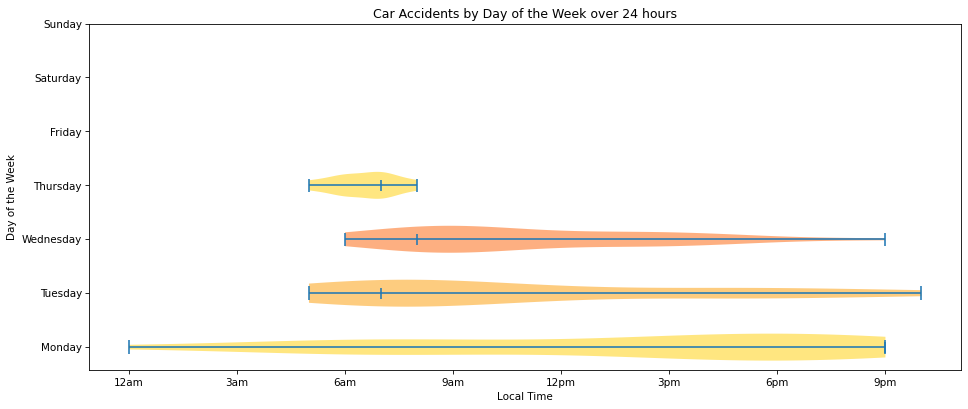

In [14]:
# Turn the start times into actual datetimes
data['Start_Time'] = pd.to_datetime(data['Start_Time'], infer_datetime_format=True)

# create a list of lists with each inner list representing a different day of the week that contains the hours that an accident occurs
data['Day'] = data['Start_Time'].apply(lambda x: x.dayofweek)
data['Hour'] = data['Start_Time'].apply(lambda x: x.hour)
grouped_by_day = data.groupby(by='Day')
hour_foreach_day = grouped_by_day.apply(lambda x: x['Hour'].tolist()).tolist()

# create the violin plot
plt_params['figure.figsize'] = (15, 6)
fig, ax = plt.subplots()
violins = ax.violinplot(dataset=hour_foreach_day, positions=range(len(hour_foreach_day)), vert=False)

# add lines marking the mode for each day, representing the time where most accidents happen
bodies = violins['bodies']
modes = [mode(x) for x in hour_foreach_day]
ax.vlines(modes, list(map(lambda x: x-0.1, range(len(bodies)))), list(map(lambda x: x+0.1, range(len(bodies)))))

# add colors to help differentiate each violin
for i in range(len(bodies)):
    bodies[i].set_facecolor(color_scheme[i % 3 + 1])
    bodies[i].set_alpha(0.5)

# add labels to plot
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Car Accidents by Day of the Week over 24 hours")
plt.xlabel("Local Time")
plt.ylabel("Day of the Week")
plt.xticks(ticks=[0, 3, 6, 9, 12, 15, 18, 21], labels=["12am", "3am", "6am", "9am", "12pm", "3pm", "6pm", "9pm"])
plt.show()

This graph makes sense if we take some prior assumptions into account. On the weekdays we can see humps at around 7-8am and again around 4pm. On the weekends we see more humps at midday and in the afternoon. This coincides with times when people usually go to work, leave work, and go out on weekends. During these times there are likely to be more cars on the road, leading to more accidents.

### Accidents Over the Past Few Years
We can look at the times that accidents happen more generally. Let's consider the average severity of accidents over the entire timespan. We take the average accident severity for each year of collected data from 2016-2021.

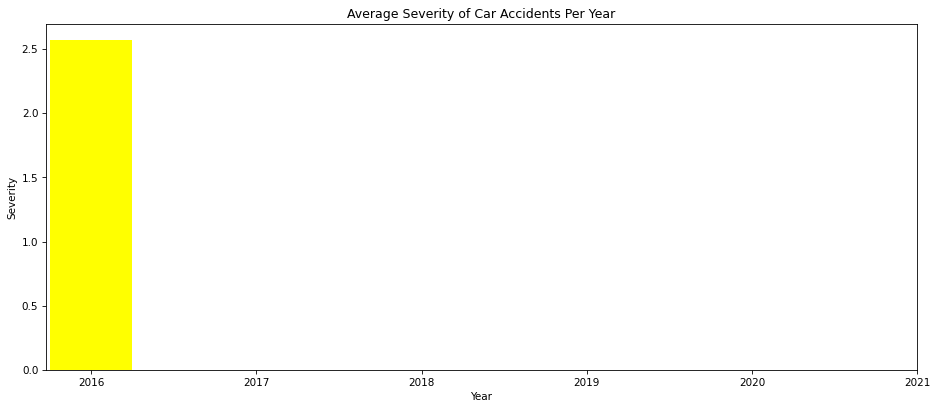

In [46]:
data['Year'] = data['Start_Time'].apply(lambda x: x.year)
grouped_by_year = data.groupby(by='Year')
severities = grouped_by_year.apply(lambda x: x['Severity'].mean())
plt.bar(height=severities, x=severities.index, width=0.5, color=gen_colors(severities, "yellow", "orange"))
plt.xticks(range(2016, 2022))
plt.title('Average Severity of Car Accidents Per Year')
plt.xlabel('Year')
plt.ylabel('Severity')
plt.show()

It seems like accident severity has been tending down over the last four years. There may be no significant reason for this, but one possibility is that there were less cars on the road over the COVID-19 time period.

## Graphing Accident Weather
We have a lot of columns related to weather. We proceed by making some graphs based on the weather conditions during accidents.

First we consider the `Weather_Condition` column. We can take a look at the different values in this column.

In [14]:
data['Weather_Condition'].value_counts().to_csv('weather_conditions.csv') # Open weather_conditions.csv to look for yourself

There are quite a lot of different values to analyze. Let's take a look at the top 6 most common conditions and compare the number of accidents for each of them.

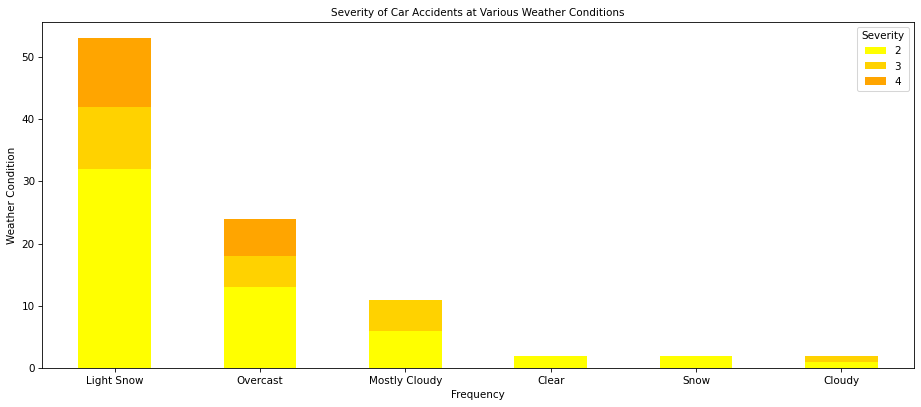

In [48]:
data.groupby(['Weather_Condition', 'Severity']).size().unstack().sort_values(
    by=2, ascending=False)[:6].plot(kind='bar', stacked=True, xlabel='Frequency', ylabel='Weather Condition', color=gen_colors(range(3), "yellow", "orange"))
plt.xticks(rotation = 0)
plt.title('Severity of Car Accidents at Various Weather Conditions', fontsize=10)
plt.show()

If we take a closer look at the weather conditions, some of them are very similar to each other (What's the difference between "Thunder" and "T-Storm"?). We make broader categories for some of these weather conditions so we can analyze them better. The categories we chose are
- Snow (Anything related to snow, winter, freezing, hail, or ice)
- Rain (Anything related to rain, drizzle, thunder, storm, or precipitation)
- Cloudy (Anything related to cloud or overcast)
- Clear (Anything related to clear or fair)

In [51]:
def classify_weather(weather, keywords):
    # check if the data is missing (nan)
    if type(weather) != str:
        return 0
    return int(any(x in weather for x in keywords))

# The list of weather options
# Feel free to edit this dict to add more options!
weathers = {'Snow': ['Snow', 'Freez', 'Hail', 'Ice', 'Wint'], 'Rain': ['Rain', 'Drizzle', 'Thunder', 'Storm', 'Precipitation'],
            'Cloudy': ['Cloud', 'Overcast'], 'Clear': ['Clear', 'Fair']}

# Make a new column for each weather option
# For each accident, "1" means the weather condition had the keyword for this weather option, else "0"
for key, value in weathers.items():
    data[key] = data['Weather_Condition'].apply(lambda x: classify_weather(x, value))

Now we compare the severity of accidents based on the selected weather conditions.

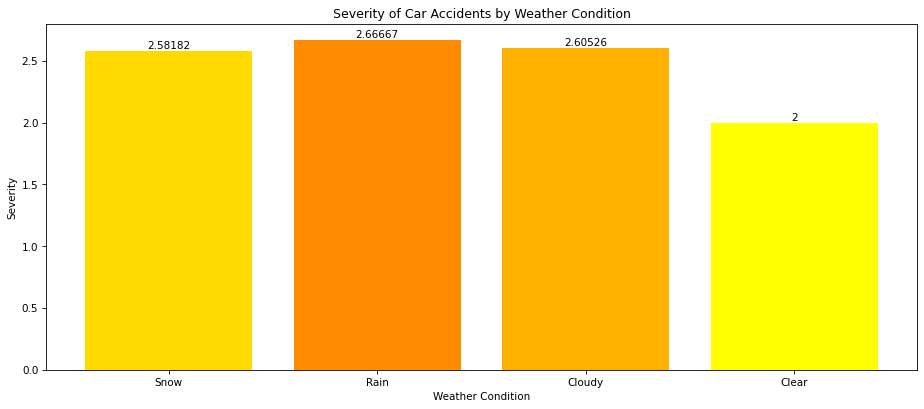

In [55]:
# Take the mean for each weather option
weather_counts = pd.Series([data[data[x] == 1]['Severity'].mean() for x in weathers.keys()])

# Plot the graph
fix, ax = plt.subplots()
bars = ax.bar(weathers.keys(), weather_counts, color=gen_colors(weather_counts, "yellow", "darkorange"))
ax.bar_label(bars)
plt.title("Severity of Car Accidents by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Severity")
plt.show()

From this bar chart it is not very clear what the difference in weathers really is in terms of accident severity. We can tell that snowy accidents are probably more severe than clear ones, but it's not clear if this is statistically significant. However, since we are dealing with over a million data points, the small differences might add up. Let's normalize this data and plot it again.

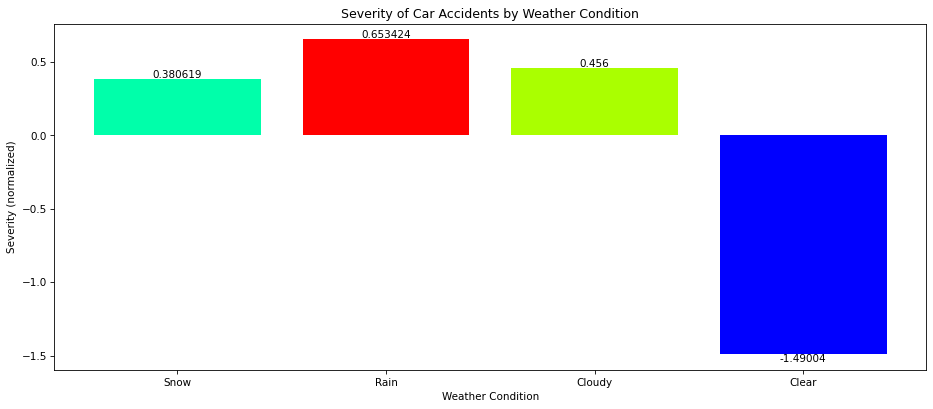

In [32]:
fix, ax = plt.subplots()

# Plot the normalized graph
bars = ax.bar(weathers.keys(), (weather_counts - weather_counts.mean())/weather_counts.std(), color=gen_colors((weather_counts - weather_counts.mean())/weather_counts.std(), "blue", "red"))
ax.bar_label(bars)
plt.title("Severity of Car Accidents by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Severity (normalized)")
plt.show()

Now we can see a clear difference in the severity. When the weather is clear, accidents are on average less severe than on days with rain or snow.

In [18]:
# plt.bar(height=data.groupby('Weather_Condition').apply(lambda x: x['Severity'].mean()), x=data.groupby('Weather_Condition').apply(lambda x: x['Severity'].mean()).index)
# plt.show()
def plot_sevs(df, feature, normalize=True):
    sevs = data.groupby(feature).apply(lambda x: x['Severity'].mean())
    if normalize:
        sevs = (sevs - sevs.mean())/sevs.std()
    plt.bar(height=sevs, x=sevs.index)
    plt.show()

In [28]:
'''
weather_features = ['Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition']

def plot_freqs(feature):
    counts = data[feature].value_counts()
    plt.scatter(x=counts.index, y=counts)
    plt.title(feature)
    plt.show()

for feat in weather_features:
    plot_freqs(feat)

data[weather_features].corr()
'''

"\nweather_features = ['Temperature(F)',\n       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',\n       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',\n       'Weather_Condition']\n\ndef plot_freqs(feature):\n    counts = data[feature].value_counts()\n    plt.scatter(x=counts.index, y=counts)\n    plt.title(feature)\n    plt.show()\n\nfor feat in weather_features:\n    plot_freqs(feat)\n\ndata[weather_features].corr()\n"

# Training the Model
Next, we train a model that predicts accident severity based on the other data points given. We expect the model to use elements such as weather, temperature, and location to make predictions on the accident severity.

In [ ]:
# model = RandomForestRegressor(random_state=42)
# model.fit(data.drop(['ID', 'Severity', 'Start_Time', 'City', 'State', 'Wind_Direction'], axis=1), data['Severity'])
# model.score(data.drop(['ID', 'Severity', 'Start_Time', 'City'], axis=1))

# Citations
- <a id="1">[1]</a> 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- <a id="2">[2]</a> 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.